In [1]:
from pathlib import Path
import urllib

pwd = !pwd
ROOT = Path(pwd[0])

def vid_to_path(vid: str):
    path = ROOT / "data" / vid[:1] / vid
    if not path.exists():
        path.mkdir(parents=True)
    return path


def yts_to_vid(yts: str):
    url_data = urllib.parse.urlparse(yts)
    query = urllib.parse.parse_qs(url_data.query)
    vid = query["v"][0]
    return vid


def yts_to_path(yts: str):
    vid = yts_to_vid(yts)
    return vid_to_path(vid)


def vid_to_yts(vid: str):
    return f"https://www.youtube.com/watch?v={vid}"

In [103]:
import pandas as pd

targets = pd.DataFrame([{
    'vid': x.parent.name,
    'target': (x.parent / "score.txt").read_text()
}
    for x in ROOT.rglob('thumb.jpg')
])
targets.to_csv('targets.csv', index=False)

Sample Solution

 1. Apply a mask to the thumbnail around Melonhead himself
 2. Extract relevant features from pixels within the mask
 3. Train classifier, profit?

In [2]:
import pandas as pd
targets = pd.read_csv("targets.csv")

In [3]:
# len(list(ROOT.rglob('thumb.jpg'))), len()

_scores = list(map(lambda x: x.parent, list(ROOT.rglob('thumb.jpg'))))
for f in list(ROOT.rglob('score.txt')):
    if f.parent not in _scores:
        shutil.rmtree(f.parent)


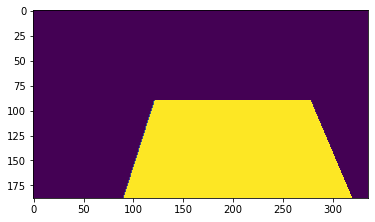

In [4]:
import numpy as np
from matplotlib import pyplot as plt


MASKING_SHAPE = (188, 336, 3)

left = lambda pt: 3.13333 * pt[1] - 470 < -pt[0]
right = lambda pt: 564 - 2.35 * pt[1] < -pt[0]
horiz = lambda pt: -90 < -pt[0] 


def get_mask(shape):
    arr = np.full(shape, False)
    for x in range(shape[1]):
        for y in range(shape[0]):
            arr[y, x] = not left((y, x)) and not right((y, x)) and not horiz((y, x))
            
    return arr

MASK = get_mask(MASKING_SHAPE[:2])
MASK = np.asarray([MASK, MASK, MASK]).transpose((1, 2, 0))
plt.imshow(MASK[:,:,0])
plt.show()


In [5]:
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

from tqdm import tqdm

NUM_CLUSTERS = 5

def get_colour(r, g, b):
    """Find a colour that is indicative of the dominant colour"""
    ar = np.asarray([np.stack((r, g, b), axis=-1)])
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    index_max = np.argmax(counts)                    # find most frequent
    peak = codes[index_max]
    r, g, b = peak
    colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
    return colour, r, g, b


def load_example(path, mask, dsfact: int = 1):
    thumb_path = path / "thumb.jpg"
    img = Image.open(thumb_path)
    if np.array(img).shape != MASK.shape:
        img = img.resize((MASK.shape[1], MASK.shape[0]), Image.ANTIALIAS)
    ds_mask = mask[::dsfact, ::dsfact, :]
    ds_img  = np.array(img)[::dsfact, ::dsfact, :]
    features = ds_img[ds_mask]
    r, g, b = ds_img[..., 0][ds_mask[..., 0]], ds_img[..., 1][ds_mask[..., 0]], ds_img[..., 2][ds_mask[..., 0]]
    return np.array(img), features, path.name, (r, g, b)


paths = list(map(vid_to_path, targets.vid))


vids = []
scores = []
features = []
rgbs = []
colours = []
for p in tqdm(paths):
    img, img_features, vid, rgb = load_example(p, MASK, 3)
    vids.append(vid)
    features.append(img_features)
    colour, r, g, b = get_colour(*rgb)
    rgbs.append([*rgb])
    colours.append(colour)


100%|██████████| 2492/2492 [01:24<00:00, 29.45it/s]


In [6]:
import sklearn.preprocessing

rgb_features = []
for rgb, colour in tqdm(zip(rgbs, colours)):
    rgb_features.append(
        pd.Series(rgb[0]).describe().tolist()
        + pd.Series(rgb[1]).describe().tolist()
        + pd.Series(rgb[2]).describe().tolist()
        + list(map(lambda x: int(x, 16), [colour[0:2], colour[2:4], colour[4:6]]))
    )

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(rgb_features)
rgb_features = scaler.transform(rgb_features)

2492it [00:09, 252.81it/s]


In [7]:
target_val = targets['target'].apply(lambda x: int(x) if x.isnumeric() else (10 if x == "CLASSIC" else 0))
target_val

0        9
1        7
2        6
3        8
4        4
        ..
2487     6
2488    10
2489     8
2490     0
2491     8
Name: target, Length: 2492, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    np.asarray(rgb_features), 
    target_val, 
    test_size=0.33, 
    random_state=42
)

from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=0, verbose=True, n_jobs=8)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

y_test_int = pd.Series(y_test).apply(int)
y_pred_int = pd.Series(y_pred).apply(int)

average_error = np.mean(np.abs(y_test_int - y_pred_int))
average_error


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1.6914893617021276

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as cm

regr = RandomForestClassifier(random_state=0, verbose=True, n_jobs=8, class_weight='balanced')

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

cm(y_test, y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[12,  1,  0,  1,  1,  2,  3,  8,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  1,  4,  2,  0,  0],
       [ 0,  0,  0,  3,  2,  1,  8,  3,  8,  0,  0],
       [ 1,  0,  0,  2,  9,  3,  9, 24, 14,  0,  0],
       [ 1,  0,  0,  2,  3, 11, 39, 51, 24,  0,  0],
       [ 2,  0,  0,  0,  4, 18, 42, 65, 25,  1,  0],
       [ 1,  0,  0,  1,  0, 21, 43, 83, 30,  1,  2],
       [ 1,  0,  0,  1,  2, 13, 44, 57, 65,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  2, 22,  0,  0],
       [ 0,  0,  0,  1,  0,  2,  5,  4,  4,  0,  0]])